In [1]:
import requests
import json
import time
import itertools
import wget
import os
import pickle
import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import precision_recall_curve
import scipy

sns.set_style('white')
import tensorflow as tf
import pandas as pd
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.initializers as init
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [2]:
x_train_dict = pickle.load(open('training_num.pik' , 'rb'))

In [3]:
train_split = 8000

In [4]:
x_train_raw = x_train_dict['images']

x_train = np.array(x_train_raw)[:train_split,: ,: , :]
x_test  = np.array(x_train_raw)[train_split:,: ,: , :]

print x_train.shape

(8000, 128, 85, 3)


In [5]:
img_rows = x_train.shape[1]

img_cols = x_train.shape[2]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
    
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


In [6]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255.0
x_test  /= 255.0

print 'x_train shape:', x_train.shape
print  x_train.shape[0], 'train samples'

print 'x_test shape:', x_test.shape
print  x_test.shape[0], 'test samples'

x_train shape: (8000, 128, 85, 3)
8000 train samples
x_test shape: (1988, 128, 85, 3)
1988 test samples


In [7]:
y_raw = pd.read_csv('Genres_labels_All_cleaned.csv')

y_train = y_raw.iloc[:, 1:-1].values[:train_split, :]
y_test  = y_raw.iloc[:, 1:-1].values[train_split:, :]

num_classes = y_train.shape[1]

print 'number of classes:  ' , num_classes

number of classes:   14


In [8]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.5,
    fill_mode = 'wrap')

datagen.fit(x_train)

datagen.fit(x_test)

In [34]:
# create an empty network model
modelb = Sequential()

# --- input layer ---
modelb.add(Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=input_shape , 
                 kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.3))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# --- max pool ---
modelb.add(MaxPooling2D(pool_size=(2, 2)))


# -----------------------------------------------------------------------------------------------

# ---- Conv Layer ---
modelb.add(Conv2D(32, kernel_size=(5, 5), activation='relu', 
                kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.3))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# --- max pool ---
modelb.add(MaxPooling2D(pool_size=(2, 2)))


# -----------------------------------------------------------------------------------------------

# --- Conv layer ---
modelb.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
               kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.3))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# --- max pool ---
modelb.add(MaxPooling2D(pool_size=(2, 2)))

# -----------------------------------------------------------------------------------------------

# --- Conv layer ---
modelb.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ,
               kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.3))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# --- max pool ---
modelb.add(MaxPooling2D(pool_size=(2, 2)))

#------------------------------------------------------------------------------------------------

# flatten for fully connected classification layer
modelb.add(Flatten())

# --- fully connected layer ---
modelb.add(Dense(128, activation='relu',
              kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.5))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# ------------------------------------------------------------------------------------------------

# --- fully connected layer ---
modelb.add(Dense(64, activation='relu' ,
               kernel_initializer = init.he_normal(109)))

# ------Dropout -------
modelb.add(Dropout(0.5))

# -----Batch Normalization -----
modelb.add(BatchNormalization())

# ------------------------------------------------------------------------------------------------

# --- classification ---
modelb.add(Dense(num_classes, activation='sigmoid'))

# prints out a summary of the model architecture
modelb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 122, 79, 32)       4736      
_________________________________________________________________
dropout_31 (Dropout)         (None, 122, 79, 32)       0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 122, 79, 32)       128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 61, 39, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 57, 35, 32)        25632     
_________________________________________________________________
dropout_32 (Dropout)         (None, 57, 35, 32)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 57, 35, 32)        128       
__________

In [35]:
sgd = SGD(lr=1e-4 , momentum = 0.99)
modelb.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [36]:
# Batch Size
batch_size = 128

# epochs
epochs = 100

In [37]:
history = modelb.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch = len(x_train) / batch_size, 
                              epochs=epochs,
                              validation_data = (x_test, y_test),
                              validation_steps = len(x_test) / batch_size)

Epoch 1/100
62/62 [==============================] - 16s - loss: 0.8655 - acc: 0.5019 - val_loss: 0.6862 - val_acc: 0.5225

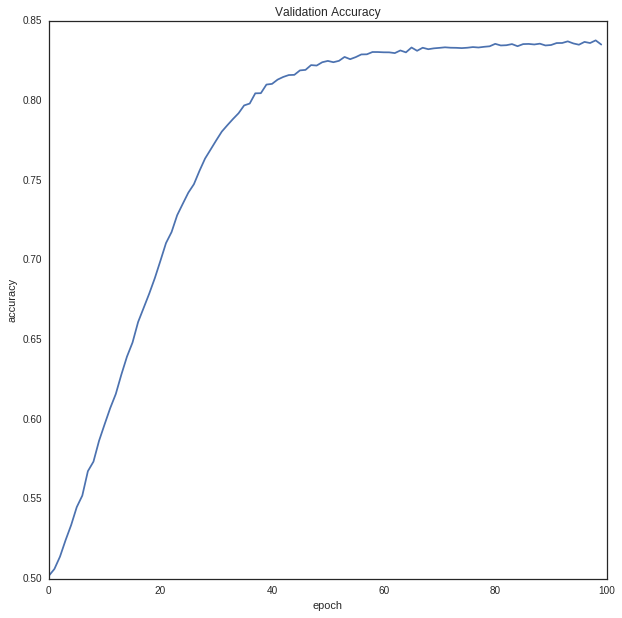

In [38]:
fig = plt.figure (figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(history.history['acc'])
ax1.set_xlabel("epoch")
ax1.set_title('Validation Accuracy')
ax1.set_ylabel("accuracy")
plt.show()

In [39]:
import h5py as h5py

In [40]:
modelb.save('cnn_b.h5')

In [41]:
Acc_arch1_var4 = pd.DataFrame(history.history['acc'] , columns = ['Accuracy'])

In [42]:
Acc_arch1_var4.to_csv('varb_acc.csv')